In [1]:
import tensorflow as tf
import h5py 
import matplotlib.pyplot as plt
import numpy as np
import timeit
from sklearn import preprocessing

/anaconda3/envs/anacondapy2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# batched data generating function

In [2]:
def batch_generator(filename, batch_size):
    f = h5py.File(filename, 'r')
    batch_count = 0
    while True:
        if batch_count * batch_size + batch_size > f['label'].shape[0]: #若batchsize不能整除的話，最後餘下的資料永遠不會讀出
            batch_count = 0
        start_idx = batch_count * batch_size
        end_idx = start_idx + batch_size
        batch_count += 1
        yield f['data'][start_idx : end_idx] , f['label'][start_idx : end_idx]
    f.close()

# weight function

In [3]:
def w(shape): #weight
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1), name='w')

def b(shape): #bias
    return tf.Variable(tf.constant(0.1,shape=shape), name='b')

def conv2d(x,w): #x:輸入影像，須為4維張量。 w:filter權重
    return tf.nn.conv2d(x, w, strides=[1,1,1,1], padding='SAME')

def maxpool2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')


# model

In [4]:
pr = 2
traindatafile_ =  '/Volumes/Mac/GW/spec/withoutoverlap/5~75/trainingdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5'
modelstore = '/Volumes/Mac/GW/model/model-resnet6.ckpt'

In [5]:
f = h5py.File(traindatafile_, 'r')
ll = len(f['data'])
print ll

6312


In [6]:
sample_rate = 8192
data_length = 8192 
T = data_length / sample_rate

nitv = 16.0
novl = 8.0
#f
lenf = int(sample_rate/nitv/2+1)
print 'lenth f =',lenf
#t
lent = int((nitv*T-1)*novl+1)
print 'lenth t =',lent

#idx of f=512
idx512 = (lenf-1)/8
print 'idx512=',idx512


batchSize = 24
print 'batch size =' ,batchSize
datasize = ll
totalBatchs = datasize/batchSize

c1fs = 11 #conv1 filter size
c1fn = 4 #conv1 output channel number
c2fs = 11 #conv2 filter size
c2fn = 4 #conv2 output channel number
c3fs = 8 #conv3 filter size
c3fn = 5 #conv3 output channel number
c4fs = 8 #conv4 filter size
c4fn = 5 #conv4 output channel number
c5fs = 5 #conv5 filter size
c5fn = 6 #conv5 output channel number
c6fs = 5 #conv6 filter size
c6fn = 6 #conv6 output channel number
dos1 = idx512+1 #1st dim of spectrogram
dos2 = lent #2nd din of spectrogram
lnn1 = 128 #layer1 neuron number
lnn2 =32 #layer1 neuron number

lenth f = 257
lenth t = 121
idx512= 32
batch size = 24


In [8]:
with tf.name_scope('input_layer'):
    x = tf.placeholder('float', shape=[None, dos1, dos2], name='x')
    x_image = tf.reshape(x, [-1, dos1, dos2, 1]) #(筆數,頻率維度,時間維度,顏色維度)
    
with tf.name_scope('pool'):
    pool = maxpool2x2(x_image)
    #print pool.shape.as_list()

with tf.name_scope('c1_conv'):
    w1 = w([c1fs ,c1fs ,1, c1fn])
    b1 = b([c1fn])
    conv1 = conv2d(pool, w1) + b1
    c1_conv = tf.nn.relu(conv1)
    #print  conv1.shape.as_list()
    
with tf.name_scope('c2_conv'):
    w2 = w([c2fs ,c2fs , c1fn, c2fn])
    b2 = b([c2fn])
    conv2 = conv2d(c1_conv,w2) +b2
    
    increase_dim_c2 = conv2.shape.as_list()[3]-pool.shape.as_list()[3]
    zeropadding_c2 = tf.zeros_like(conv2)[:,:,:,0:increase_dim_c2]
    #shortcut connection
    c2_rl = conv2 + tf.concat([pool,zeropadding_c2], 3)
    c2_conv = tf.nn.relu(c2_rl)
    #print conv2.shape.as_list()
    
with tf.name_scope('c2_pool'):
    c2_pool = maxpool2x2(c2_conv)
    #print  c2_pool.shape.as_list()
    
with tf.name_scope('c3_conv'):
    w3 = w([c3fs ,c3fs ,c2fn, c3fn])
    b3 = b([c3fn])
    conv3 = conv2d(c2_pool, w3) + b3
    c3_conv = tf.nn.relu(conv3)
    #print conv3.shape.as_list()
    
with tf.name_scope('c4_conv'):
    w4 = w([c4fs ,c4fs ,c3fn, c4fn])
    b4 = b([c4fn])
    conv4 = conv2d(c3_conv, w4) + b4
    
    increase_dim_c4 = conv4.shape.as_list()[3]-c2_pool.shape.as_list()[3]
    zeropadding_c4 = tf.zeros_like(conv4)[:,:,:,0:increase_dim_c4]
    #shortcut connection
    c4_rl = conv4 + tf.concat([c2_pool,zeropadding_c4], 3)
    c4_conv = tf.nn.relu(c4_rl)
    #print conv4.shape.as_list()
    
with tf.name_scope('c4_pool'):
    c4_pool = maxpool2x2(c4_conv)
    #print c4_pool.shape.as_list()
    
with tf.name_scope('c5_conv'):
    w5 = w([c5fs ,c5fs ,c4fn, c5fn])
    b5 = b([c5fn])
    conv5 = conv2d(c4_pool, w5) + b5
    c5_conv = tf.nn.relu(conv5)
    #print conv5.shape.as_list()
    
with tf.name_scope('c6_conv'):
    w6 = w([c6fs ,c6fs ,c5fn, c6fn])
    b6 = b([c6fn])
    conv6 = conv2d(c5_conv, w6) + b6
    
    increase_dim_c6 = conv6.shape.as_list()[3]-c4_pool.shape.as_list()[3]
    zeropadding_c6 = tf.zeros_like(conv6)[:,:,:,0:increase_dim_c6]
    #shortcut connection
    c6_rl = conv6 + tf.concat([c4_pool,zeropadding_c6], 3)
    c6_conv = tf.nn.relu(c6_rl)
    #print conv6.shape.as_list()

#neurons = dos1/8*dos2/8*c3fn
with tf.name_scope('D_flat'):
    D_Flat = tf.layers.Flatten()(c6_conv)
    #print D_Flat.shape.as_list()

with tf.name_scope('D_hidden_layer1'):
    inputdim = D_Flat.shape.as_list()[1]
    wl1 = w([inputdim, lnn1])
    bl1 = b([lnn1])
    D_hidden1 = tf.nn.relu(tf.matmul(D_Flat, wl1)+bl1)
    #print D_hidden1.shape.as_list()
    
with tf.name_scope('D_hidden_layer2'):
    wl2 = w([lnn1, lnn2])
    bl2 = b([lnn2])
    D_hidden2 = tf.nn.relu(tf.matmul(D_hidden1, wl2)+bl2)
    #print D_hidden2.shape.as_list()
    
with tf.name_scope('output_layer'):
    wo = w([lnn2,2])
    bo = b([2])
    #y_predict = tf.sigmoid(tf.matmul(D_hidden2,wo)+bo)
    y_predict = tf.nn.softmax(tf.matmul(D_hidden2,wo)+bo)
    
with tf.name_scope('optimizer'):
    y_label = tf.placeholder('float', shape=[None,2], name='y_label')
    #lossfunction = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_predict, labels=y_label))
    lossfunction = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_predict, labels=y_label))
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(lossfunction)
    
with tf.name_scope('evaluate_model'):
    correct_prediction = tf.equal(tf.argmax(y_predict,1), tf.argmax(y_label,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,'float'))

[None, 17, 61, 1]
[None, 17, 61, 4]
[None, 17, 61, 4]
[None, 9, 31, 4]
[None, 9, 31, 5]
[None, 9, 31, 5]
[None, 5, 16, 5]
[None, 5, 16, 6]
[None, 5, 16, 6]
[None, 480]
[None, 128]
[None, 32]


# evaluate

In [8]:
def evaluate(trainEpochs,peakratio):

    start_time = timeit.default_timer()
    sess = tf.Session()

    saver = tf.train.Saver()

    try: #第一次之後執行
        saver.restore(sess, modelstore)
    except: #第一次跑時執行
        sess.run(tf.global_variables_initializer())

    traindatafile =  '/Volumes/Mac/GW/spec/withoutoverlap/5~75/trainingdatawo_spec16-8_freq512_pr'+str(peakratio)+'_mr<=10.h5'
    valdatafile = '/Volumes/Mac/GW/spec/overlap/5~75/validationdata_spec16-8_freq512_pr'+str(peakratio)+'_mr<=10.h5'
    
    
    bg = batch_generator(traindatafile, batchSize)
    fval = h5py.File(valdatafile, 'r')
    val_x = fval['data'][...]
    val_y = fval['label'][...]
    #np_utils.to_categorical
    for epoch in range(trainEpochs):
        for i in range(totalBatchs):
            #每次讀取100筆資料
            batch_x, batch_y = next(bg)
            #將feature和label輸入並計算執行圖
            sess.run(optimizer, feed_dict={x : batch_x, y_label : sess.run(tf.one_hot(batch_y, 2)) })
        #使用驗證資料計算一次epoch的loss和acc    
        loss, acc = sess.run([lossfunction,accuracy],feed_dict={x : val_x, y_label : sess.run(tf.one_hot(val_y, 2))})
    
        print 'Train Epoch:', '%02d'%(epoch+1), 'Loss=', '{:.9f}'.format(loss), 'Accuracy=',acc
    

    saver.save(sess, modelstore)

    fval.close()
    stop_time = timeit.default_timer()
    print 'period(s) =', stop_time - start_time
    
    
def estimate(testdatafile):
    sess = tf.Session()
    saver = tf.train.Saver()
    saver.restore(sess, modelstore)
    ftest = h5py.File(testdatafile, 'r')
    test_x = ftest['data'][...]
    test_y = ftest['label'][...]
    ftest.close()
    
    start_time = timeit.default_timer()
    acc =  sess.run(accuracy, feed_dict={x : test_x, y_label : sess.run(tf.one_hot(test_y, 2)) })
    print 'acc :', acc
    stop_time = timeit.default_timer()
    print 'period of estimate =', stop_time - start_time, '(s)'
    return acc
    
def prediction_result(testdatafile):
    sess = tf.Session()
    saver = tf.train.Saver()
    saver.restore(sess, modelstore)
    ftest = h5py.File(testdatafile, 'r')
    test_x = ftest['data'][...]
    test_y = ftest['label'][...]
    ftest.close()
    
    start_time = timeit.default_timer()
    predictresult = sess.run(tf.argmax(y_predict, 1), feed_dict={x : test_x, y_label : sess.run(tf.one_hot(test_y, 2))})
    stop_time = timeit.default_timer()
    print 'period of prediction =', stop_time - start_time, '(s)'
    return predictresult

In [11]:
def relation(n):
    d = '/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr0.5_2time10_'
    rm = np.zeros([70,70])
    cm = np.zeros([2,2])
    for j in range(n):
        data =  d+str(j)+'_mr<=10.h5'
        test = h5py.File(data, 'r')
        test_par = test['parameter'][...]
        test_lab = test['label'][...]
        test.close()
        predict = prediction_result(data)
        cm += confusionmatrix(predict,test_lab)
        for i in range(len(test_par)):
            if test_par[i,0] != 0: #選擇有訊號的數據
                if test_lab[i] != predict[i]: #預測不正確則顏色加深
                    row = int(test_par[i,0]-5.5)
                    col =  int(test_par[i,1]-5.5)
                    rm[row,col] += 1.
    acc(cm)
    sensitivity(cm)
    false_alarm_rate(cm)
    scale = preprocessing.MinMaxScaler(feature_range=(0,1))
    rmr = rm.reshape(70*70,1)
    rmrn = scale.fit_transform(rmr)
    rm = rmrn.reshape(70, 70)
    
    plt.imshow(rm, cmap='binary')
    tick_idx = [0,10,20,30,40,50,60]
    tick_mass = [5.5,15.5,25.5,35.5,45.5,55.5,65.5]
    plt.yticks(tick_idx , tick_mass)
    plt.xticks(tick_idx , tick_mass)
    plt.xlabel('m2')
    plt.ylabel('m1')

def confusionmatrix(prediction_result,test_y):
    sess = tf.Session()
    cm = sess.run(tf.confusion_matrix(test_y, prediction_result))
    print 'confusionmatrix ='
    print cm
    return cm

def false_alarm_rate(cm):
    fp = cm[0,1].astype('float64')
    tn = cm[0,0].astype('float64')
    print 'false alarm rate =',fp/(fp+tn) #false alarm rate
    return fp/(fp+tn)

def sensitivity(cm):
    tp = cm[1,1].astype('float64')
    fn = cm[1,0].astype('float64')
    print 'sensitivity =',tp/(tp+fn) #sensitivity
    return tp/(tp+fn)

def acc(cm):
    print 'acc =',(cm[0,0]+cm[1,1])/np.sum(cm)
def summary():
    estimate()
    pr = prediction_result()
    cm = confusionmatrix(pr)
    false_alarm_rate(cm)
    sensitivity(cm)

In [10]:
th = h5py.File('/Volumes/Mac/GW/traininghistory', 'a')
th.create_dataset('sen', (8,), maxshape=(None,))
th.create_dataset('far', (8,), maxshape=(None,))
th.create_dataset('acc', (8,), maxshape=(None,))
th.create_dataset('pr', (8,), maxshape=(None,))

<HDF5 dataset "pr": shape (8,), type "<f4">

In [25]:
pr=2
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
Train Epoch: 01 Loss= 0.313455105 Accuracy= 1.0
Train Epoch: 02 Loss= 0.313298047 Accuracy= 1.0
Train Epoch: 03 Loss= 0.313274831 Accuracy= 1.0
Train Epoch: 04 Loss= 0.313268214 Accuracy= 1.0
period(s) = 362.884856939


In [26]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
Train Epoch: 01 Loss= 0.313265592 Accuracy= 1.0
Train Epoch: 02 Loss= 0.313264519 Accuracy= 1.0
Train Epoch: 03 Loss= 0.313263834 Accuracy= 1.0
Train Epoch: 04 Loss= 0.313263535 Accuracy= 1.0
period(s) = 462.610044003


In [11]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
Train Epoch: 01 Loss= 0.313263357 Accuracy= 1.0
Train Epoch: 02 Loss= 0.313263088 Accuracy= 1.0
Train Epoch: 03 Loss= 0.313263029 Accuracy= 1.0
Train Epoch: 04 Loss= 0.313262850 Accuracy= 1.0
period(s) = 303.68611908


In [12]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
Train Epoch: 01 Loss= 0.313262820 Accuracy= 1.0
Train Epoch: 02 Loss= 0.313262731 Accuracy= 1.0
Train Epoch: 03 Loss= 0.313262701 Accuracy= 1.0
Train Epoch: 04 Loss= 0.313262641 Accuracy= 1.0
period(s) = 468.14368391


In [12]:
a=estimate('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5')
th['acc'][0]=a

testd = h5py.File('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5', 'r')
testd_lab = testd['label'][...]
testd.close()
cm = confusionmatrix(prediction_result('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5'),
               testd_lab)

far = false_alarm_rate(cm)
th['far'][0]=far

sen = sensitivity(cm)
th['sen'][0]=sen

th['pr'][0]=pr

print th['acc'][...]
print th['far'][...]
print th['sen'][...]
print th['pr'][...]
th.close()

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
acc : 1.0
period of estimate = 35.8873660564 (s)
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
period of prediction = 33.1561729908 (s)
confusionmatrix =
[[3682    0]
 [   0 2455]]
false alarm rate = 0.0
sensitivity = 1.0
[1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0.]
[2. 0. 0. 0. 0. 0. 0. 0.]


In [13]:
pr=1.5 ; i=1
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
Train Epoch: 01 Loss= 0.313337922 Accuracy= 1.0
Train Epoch: 02 Loss= 0.313264281 Accuracy= 1.0
Train Epoch: 03 Loss= 0.313263744 Accuracy= 1.0
Train Epoch: 04 Loss= 0.313263237 Accuracy= 1.0
period(s) = 361.537511826


In [14]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
Train Epoch: 01 Loss= 0.313262969 Accuracy= 1.0
Train Epoch: 02 Loss= 0.313262820 Accuracy= 1.0
Train Epoch: 03 Loss= 0.313262701 Accuracy= 1.0
Train Epoch: 04 Loss= 0.313262641 Accuracy= 1.0
period(s) = 500.381302118


In [10]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
Train Epoch: 01 Loss= 0.313262612 Accuracy= 1.0
Train Epoch: 02 Loss= 0.313262582 Accuracy= 1.0
Train Epoch: 03 Loss= 0.313262582 Accuracy= 1.0
Train Epoch: 04 Loss= 0.313262731 Accuracy= 1.0
period(s) = 329.601536989


In [14]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
Train Epoch: 01 Loss= 0.313264132 Accuracy= 1.0
Train Epoch: 02 Loss= 0.313262641 Accuracy= 1.0
Train Epoch: 03 Loss= 0.313262612 Accuracy= 1.0
Train Epoch: 04 Loss= 0.313262582 Accuracy= 1.0
period(s) = 641.298135996


In [15]:
th = h5py.File('/Volumes/Mac/GW/traininghistory', 'a')
a=estimate('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5')
th['acc'][i]=a

testd = h5py.File('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5', 'r')
testd_lab = testd['label'][...]
testd.close()
cm = confusionmatrix(prediction_result('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5'),
               testd_lab)

far = false_alarm_rate(cm)
th['far'][i]=far

sen = sensitivity(cm)
th['sen'][i]=sen

th['pr'][i]=pr

print th['acc'][...]
print th['far'][...]
print th['sen'][...]
print th['pr'][...]
th.close()

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
acc : 1.0
period of estimate = 33.707228899 (s)
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
period of prediction = 32.1571421623 (s)
confusionmatrix =
[[3682    0]
 [   0 2455]]
false alarm rate = 0.0
sensitivity = 1.0
[1. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 0. 0. 0. 0. 0. 0.]
[2.  1.5 0.  0.  0.  0.  0.  0. ]


In [10]:
pr=1.2 ; i=2
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
Train Epoch: 01 Loss= 0.313725173 Accuracy= 0.9996667
Train Epoch: 02 Loss= 0.314336598 Accuracy= 0.999
Train Epoch: 03 Loss= 0.314587414 Accuracy= 0.999
Train Epoch: 04 Loss= 0.313402414 Accuracy= 1.0
period(s) = 354.431602955


In [11]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
Train Epoch: 01 Loss= 0.313372463 Accuracy= 1.0
Train Epoch: 02 Loss= 0.313349217 Accuracy= 1.0
Train Epoch: 03 Loss= 0.313338190 Accuracy= 1.0
Train Epoch: 04 Loss= 0.313449025 Accuracy= 0.9996667
period(s) = 491.555459023


In [12]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
Train Epoch: 01 Loss= 0.313474327 Accuracy= 0.9996667
Train Epoch: 02 Loss= 0.313302547 Accuracy= 1.0
Train Epoch: 03 Loss= 0.313372523 Accuracy= 1.0
Train Epoch: 04 Loss= 0.313437164 Accuracy= 0.9996667
period(s) = 607.450507164


In [13]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
Train Epoch: 01 Loss= 0.313470483 Accuracy= 0.9996667
Train Epoch: 02 Loss= 0.313417017 Accuracy= 0.9996667
Train Epoch: 03 Loss= 0.313287616 Accuracy= 1.0
Train Epoch: 04 Loss= 0.313294977 Accuracy= 1.0
period(s) = 786.713264942


In [14]:
th = h5py.File('/Volumes/Mac/GW/traininghistory', 'a')
a=estimate('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5')
th['acc'][i]=a

testd = h5py.File('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5', 'r')
testd_lab = testd['label'][...]
testd.close()
cm = confusionmatrix(prediction_result('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5'),
               testd_lab)

far = false_alarm_rate(cm)
th['far'][i]=far

sen = sensitivity(cm)
th['sen'][i]=sen

th['pr'][i]=pr

print th['acc'][...]
print th['far'][...]
print th['sen'][...]
print th['pr'][...]
th.close()

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
acc : 0.99983704
period of estimate = 38.8110210896 (s)
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
period of prediction = 33.7330970764 (s)
confusionmatrix =
[[3681    1]
 [   0 2455]]
false alarm rate = 0.00027159152634437803
sensitivity = 1.0
[1.         1.         0.99983704 0.         0.         0.
 0.         0.        ]
[0.         0.         0.00027159 0.         0.         0.
 0.         0.        ]
[1. 1. 1. 0. 0. 0. 0. 0.]
[2.  1.5 1.2 0.  0.  0.  0.  0. ]


In [10]:
pr=1 ; i=3
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
Train Epoch: 01 Loss= 0.324356109 Accuracy= 0.989
Train Epoch: 02 Loss= 0.317453176 Accuracy= 0.9956667
Train Epoch: 03 Loss= 0.316086590 Accuracy= 0.99733335
Train Epoch: 04 Loss= 0.315179080 Accuracy= 0.998
period(s) = 321.113950014


In [11]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
Train Epoch: 01 Loss= 0.315153360 Accuracy= 0.99766666
Train Epoch: 02 Loss= 0.315441608 Accuracy= 0.99766666
Train Epoch: 03 Loss= 0.313986689 Accuracy= 0.9993333
Train Epoch: 04 Loss= 0.313923866 Accuracy= 0.9993333
period(s) = 462.624115944


In [12]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
Train Epoch: 01 Loss= 0.314143300 Accuracy= 0.999
Train Epoch: 02 Loss= 0.314521641 Accuracy= 0.99866664
Train Epoch: 03 Loss= 0.314600170 Accuracy= 0.99866664
Train Epoch: 04 Loss= 0.314629793 Accuracy= 0.99866664
period(s) = 570.07129693


In [10]:
pr=1 ; i=3
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
Train Epoch: 01 Loss= 0.314630657 Accuracy= 0.99866664
Train Epoch: 02 Loss= 0.314632922 Accuracy= 0.99866664
Train Epoch: 03 Loss= 0.314623654 Accuracy= 0.99866664
Train Epoch: 04 Loss= 0.314614445 Accuracy= 0.99866664
period(s) = 308.103656054


In [11]:
th = h5py.File('/Volumes/Mac/GW/traininghistory', 'a')
a=estimate('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5')
th['acc'][i]=a

testd = h5py.File('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5', 'r')
testd_lab = testd['label'][...]
testd.close()
cm = confusionmatrix(prediction_result('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5'),
               testd_lab)

far = false_alarm_rate(cm)
th['far'][i]=far

sen = sensitivity(cm)
th['sen'][i]=sen

th['pr'][i]=pr

print th['acc'][...]
print th['far'][...]
print th['sen'][...]
print th['pr'][...]
th.close()

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
acc : 0.9990223
period of estimate = 30.008813858 (s)
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
period of prediction = 28.1695399284 (s)
confusionmatrix =
[[3680    2]
 [   4 2451]]
false alarm rate = 0.0005431830526887561
sensitivity = 0.9983706720977596
[1.         1.         0.99983704 0.9990223  0.         0.
 0.         0.        ]
[0.         0.         0.00027159 0.00054318 0.         0.
 0.         0.        ]
[1.         1.         1.         0.99837065 0.         0.
 0.         0.        ]
[2.  1.5 1.2 1.  0.  0.  0.  0. ]


In [10]:
pr=0.8 ; i=4
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
Train Epoch: 01 Loss= 0.322838128 Accuracy= 0.991
Train Epoch: 02 Loss= 0.323131114 Accuracy= 0.989
Train Epoch: 03 Loss= 0.321945399 Accuracy= 0.991
Train Epoch: 04 Loss= 0.322044641 Accuracy= 0.99
period(s) = 304.796190023


In [11]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
Train Epoch: 01 Loss= 0.321723580 Accuracy= 0.99
Train Epoch: 02 Loss= 0.321150362 Accuracy= 0.991
Train Epoch: 03 Loss= 0.320881963 Accuracy= 0.992
Train Epoch: 04 Loss= 0.320790499 Accuracy= 0.9916667
period(s) = 469.793373108


In [12]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
Train Epoch: 01 Loss= 0.320912749 Accuracy= 0.9916667
Train Epoch: 02 Loss= 0.320715547 Accuracy= 0.9916667
Train Epoch: 03 Loss= 0.320607752 Accuracy= 0.992
Train Epoch: 04 Loss= 0.320731819 Accuracy= 0.9916667
period(s) = 809.166828871


In [13]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
Train Epoch: 01 Loss= 0.320894271 Accuracy= 0.9913333
Train Epoch: 02 Loss= 0.320576668 Accuracy= 0.99233335
Train Epoch: 03 Loss= 0.320620090 Accuracy= 0.9916667
Train Epoch: 04 Loss= 0.320854902 Accuracy= 0.9916667
period(s) = 730.653002977


In [14]:
th = h5py.File('/Volumes/Mac/GW/traininghistory', 'a')
a=estimate('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5')
th['acc'][i]=a

testd = h5py.File('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5', 'r')
testd_lab = testd['label'][...]
testd.close()
cm = confusionmatrix(prediction_result('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5'),
               testd_lab)

far = false_alarm_rate(cm)
th['far'][i]=far

sen = sensitivity(cm)
th['sen'][i]=sen

th['pr'][i]=pr

print th['acc'][...]
print th['far'][...]
print th['sen'][...]
print th['pr'][...]
th.close()

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
acc : 0.9944598
period of estimate = 30.3244559765 (s)
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
period of prediction = 29.2823009491 (s)
confusionmatrix =
[[3662   20]
 [  14 2441]]
false alarm rate = 0.005431830526887561
sensitivity = 0.9942973523421589
[1.         1.         0.99983704 0.9990223  0.9944598  0.
 0.         0.        ]
[0.         0.         0.00027159 0.00054318 0.00543183 0.
 0.         0.        ]
[1.         1.         1.         0.99837065 0.9942973  0.
 0.         0.        ]
[2.  1.5 1.2 1.  0.8 0.  0.  0. ]


In [10]:
pr=0.7 ; i=5
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
Train Epoch: 01 Loss= 0.341361493 Accuracy= 0.97066665
Train Epoch: 02 Loss= 0.338930279 Accuracy= 0.9726667
Train Epoch: 03 Loss= 0.338798404 Accuracy= 0.9726667
Train Epoch: 04 Loss= 0.338895142 Accuracy= 0.973
period(s) = 296.097022057


In [11]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
Train Epoch: 01 Loss= 0.339777738 Accuracy= 0.9726667
Train Epoch: 02 Loss= 0.338488400 Accuracy= 0.974
Train Epoch: 03 Loss= 0.338016510 Accuracy= 0.97366667
Train Epoch: 04 Loss= 0.336096466 Accuracy= 0.9763333
period(s) = 438.272422075


In [12]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
Train Epoch: 01 Loss= 0.336795300 Accuracy= 0.976
Train Epoch: 02 Loss= 0.336423099 Accuracy= 0.977
Train Epoch: 03 Loss= 0.335723460 Accuracy= 0.9776667
Train Epoch: 04 Loss= 0.334735125 Accuracy= 0.9766667
period(s) = 571.233883858


In [10]:
pr=0.7 ; i=5
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
Train Epoch: 01 Loss= 0.336354077 Accuracy= 0.9763333
Train Epoch: 02 Loss= 0.336783558 Accuracy= 0.97566664
Train Epoch: 03 Loss= 0.337104201 Accuracy= 0.9763333
Train Epoch: 04 Loss= 0.341752231 Accuracy= 0.96966666
period(s) = 302.954240084


In [11]:
th = h5py.File('/Volumes/Mac/GW/traininghistory', 'a')
a=estimate('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5')
th['acc'][i]=a

testd = h5py.File('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5', 'r')
testd_lab = testd['label'][...]
testd.close()
cm = confusionmatrix(prediction_result('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5'),
               testd_lab)

far = false_alarm_rate(cm)
th['far'][i]=far

sen = sensitivity(cm)
th['sen'][i]=sen

th['pr'][i]=pr

print th['acc'][...]
print th['far'][...]
print th['sen'][...]
print th['pr'][...]
th.close()

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
acc : 0.9770246
period of estimate = 35.9964549541 (s)
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
period of prediction = 31.9429810047 (s)
confusionmatrix =
[[3673    9]
 [ 132 2323]]
false alarm rate = 0.0024443237370994023
sensitivity = 0.9462321792260693
[1.         1.         0.99983704 0.9990223  0.9944598  0.9770246
 0.         0.        ]
[0.         0.         0.00027159 0.00054318 0.00543183 0.00244432
 0.         0.        ]
[1.         1.         1.         0.99837065 0.9942973  0.9462322
 0.         0.        ]
[2.  1.5 1.2 1.  0.8 0.7 0.  0. ]


In [12]:
pr=0.6 ; i=6
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
Train Epoch: 01 Loss= 0.369839191 Accuracy= 0.94133335
Train Epoch: 02 Loss= 0.364307791 Accuracy= 0.94766665
Train Epoch: 03 Loss= 0.365085006 Accuracy= 0.94766665
Train Epoch: 04 Loss= 0.365206867 Accuracy= 0.94733334
period(s) = 475.591362


In [10]:
pr=0.6 ; i=6
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
Train Epoch: 01 Loss= 0.363795906 Accuracy= 0.947
Train Epoch: 02 Loss= 0.362101555 Accuracy= 0.9493333
Train Epoch: 03 Loss= 0.362537146 Accuracy= 0.948
Train Epoch: 04 Loss= 0.363909274 Accuracy= 0.94766665
period(s) = 324.352168798


In [11]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
Train Epoch: 01 Loss= 0.362600029 Accuracy= 0.9483333
Train Epoch: 02 Loss= 0.364353478 Accuracy= 0.94766665
Train Epoch: 03 Loss= 0.360737860 Accuracy= 0.95133334
Train Epoch: 04 Loss= 0.360894948 Accuracy= 0.95133334
period(s) = 434.718493938


In [12]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
Train Epoch: 01 Loss= 0.361705393 Accuracy= 0.9496667
Train Epoch: 02 Loss= 0.361591429 Accuracy= 0.9493333
Train Epoch: 03 Loss= 0.361851394 Accuracy= 0.95
Train Epoch: 04 Loss= 0.362183034 Accuracy= 0.9496667
period(s) = 828.359956026


In [13]:
th = h5py.File('/Volumes/Mac/GW/traininghistory', 'a')
a=estimate('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5')
th['acc'][i]=a

testd = h5py.File('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5', 'r')
testd_lab = testd['label'][...]
testd.close()
cm = confusionmatrix(prediction_result('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5'),
               testd_lab)

far = false_alarm_rate(cm)
th['far'][i]=far

sen = sensitivity(cm)
th['sen'][i]=sen

th['pr'][i]=pr

print th['acc'][...]
print th['far'][...]
print th['sen'][...]
print th['pr'][...]
th.close()

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
acc : 0.95665634
period of estimate = 46.0437259674 (s)
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
period of prediction = 44.4354989529 (s)
confusionmatrix =
[[3554  128]
 [ 138 2317]]
false alarm rate = 0.03476371537208039
sensitivity = 0.9437881873727088
[1.         1.         0.99983704 0.9990223  0.9944598  0.9770246
 0.95665634 0.        ]
[0.         0.         0.00027159 0.00054318 0.00543183 0.00244432
 0.03476372 0.        ]
[1.         1.         1.         0.99837065 0.9942973  0.9462322
 0.9437882  0.        ]
[2.  1.5 1.2 1.  0.8 0.7 0.6 0. ]


In [10]:
pr=0.5 ; i=7
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
Train Epoch: 01 Loss= 0.417520106 Accuracy= 0.893
Train Epoch: 02 Loss= 0.411527544 Accuracy= 0.899
Train Epoch: 03 Loss= 0.411062747 Accuracy= 0.8983333
Train Epoch: 04 Loss= 0.409013182 Accuracy= 0.89933336
period(s) = 361.567562103


In [11]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
Train Epoch: 01 Loss= 0.408165514 Accuracy= 0.90166664
Train Epoch: 02 Loss= 0.408462673 Accuracy= 0.90166664
Train Epoch: 03 Loss= 0.408573091 Accuracy= 0.90166664
Train Epoch: 04 Loss= 0.409887165 Accuracy= 0.901
period(s) = 497.879888058


In [10]:
pr=0.5 ; i=7
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
Train Epoch: 01 Loss= 0.410813689 Accuracy= 0.8986667
Train Epoch: 02 Loss= 0.410595298 Accuracy= 0.901
Train Epoch: 03 Loss= 0.411703616 Accuracy= 0.8973333
Train Epoch: 04 Loss= 0.416012168 Accuracy= 0.89433336
period(s) = 331.251412153


In [11]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
Train Epoch: 01 Loss= 0.414792389 Accuracy= 0.896
Train Epoch: 02 Loss= 0.413988531 Accuracy= 0.89533335
Train Epoch: 03 Loss= 0.413285524 Accuracy= 0.89633334
Train Epoch: 04 Loss= 0.411606848 Accuracy= 0.90033334
period(s) = 480.235358


In [12]:
th = h5py.File('/Volumes/Mac/GW/traininghistory', 'a')
a=estimate('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5')
th['acc'][i]=a

testd = h5py.File('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5', 'r')
testd_lab = testd['label'][...]
testd.close()
cm = confusionmatrix(prediction_result('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5'),
               testd_lab)

far = false_alarm_rate(cm)
th['far'][i]=far

sen = sensitivity(cm)
th['sen'][i]=sen

th['pr'][i]=pr

print th['acc'][...]
print th['far'][...]
print th['sen'][...]
print th['pr'][...]
th.close()

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
acc : 0.89261854
period of estimate = 40.5154869556 (s)
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
period of prediction = 36.1260659695 (s)
confusionmatrix =
[[3408  274]
 [ 385 2070]]
false alarm rate = 0.07441607821835959
sensitivity = 0.8431771894093686
[1.         1.         0.99983704 0.9990223  0.9944598  0.9770246
 0.95665634 0.89261854]
[0.         0.         0.00027159 0.00054318 0.00543183 0.00244432
 0.03476372 0.07441608]
[1.         1.         1.         0.99837065 0.9942973  0.9462322
 0.9437882  0.8431772 ]
[2.  1.5 1.2 1.  0.8 0.7 0.6 0.5]


INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
period of prediction = 31.645966053 (s)
confusionmatrix =
[[ 502   43]
 [ 769 4141]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
period of prediction = 30.4211230278 (s)
confusionmatrix =
[[ 507   38]
 [ 780 4130]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
period of prediction = 28.5422689915 (s)
confusionmatrix =
[[ 516   29]
 [ 785 4125]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
period of prediction = 28.3029119968 (s)
confusionmatrix =
[[ 503   42]
 [ 741 4169]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
period of prediction = 29.342854023 (s)
confusionmatrix =
[[ 508   37]
 [ 771 4139]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
period of prediction = 30.9592158794 (s)
confusionmatrix =
[[ 508   37]
 [

confusionmatrix =
[[ 502   43]
 [ 780 4130]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
period of prediction = 26.7956318855 (s)
confusionmatrix =
[[ 520   25]
 [ 691 4219]]
acc = 0.8536535288725939
sensitivity = 0.844969450101833
false alarm rate = 0.06811009174311927


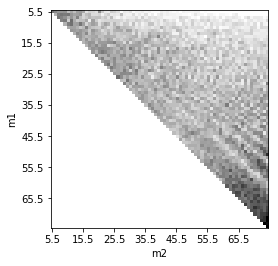

In [12]:
relation(50)

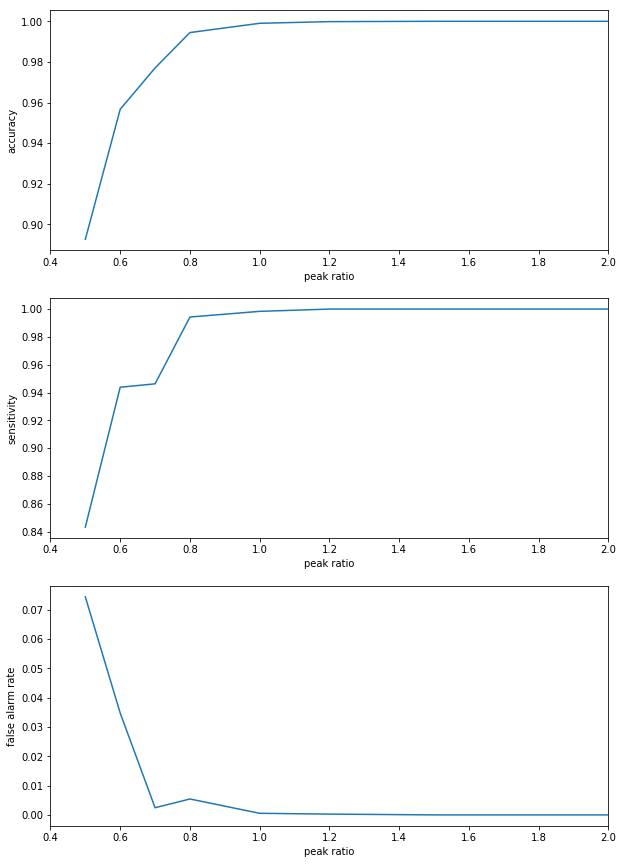

In [10]:
th = h5py.File('/Volumes/Mac/GW/traininghistory/traininghistory-resnet6', 'a')
plt.figure(figsize=(10,15))
plt.subplot(311)
plt.plot(th['pr'][...],th['acc'][...])
plt.xlabel('peak ratio')
plt.ylabel('accuracy')
plt.xlim(0.4,2)
plt.subplot(312)
plt.plot(th['pr'][...],th['sen'][...])
plt.xlabel('peak ratio')
plt.ylabel('sensitivity')
plt.xlim(0.4,2)
plt.subplot(313)
plt.plot(th['pr'][...],th['far'][...])
plt.xlabel('peak ratio')
plt.ylabel('false alarm rate')
plt.xlim(0.4,2)
th.close() 

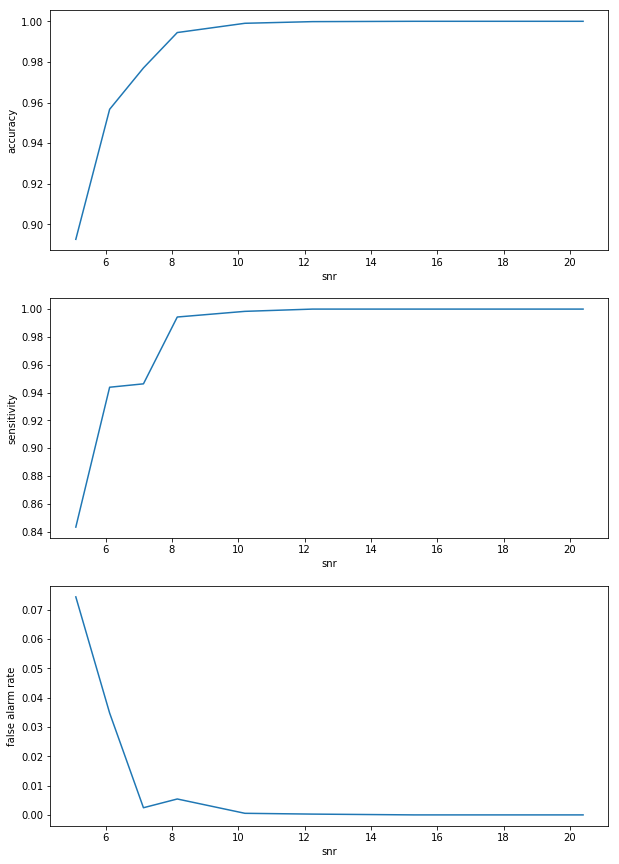

In [16]:
th = h5py.File('/Volumes/Mac/GW/traininghistory/traininghistory-resnet6', 'a')
plt.figure(figsize=(10,15))
plt.subplot(311)
plt.plot(th['pr'][...]*10.2,th['acc'][...])
plt.xlabel('snr')
plt.ylabel('accuracy')

plt.subplot(312)
plt.plot(th['pr'][...]*10.2,th['sen'][...])
plt.xlabel('snr')
plt.ylabel('sensitivity')

plt.subplot(313)
plt.plot(th['pr'][...]*10.2,th['far'][...])
plt.xlabel('snr')
plt.ylabel('false alarm rate')

plt.savefig('training result_10',dpi=600)
th.close() 

In [24]:
th = h5py.File('/Volumes/Mac/GW/traininghistory/traininghistory-resnet6', 'a')
plt.figure(figsize=(10,15))
plt.subplot(311)
plt.plot(th['pr'][...]*10.2,th['acc'][...])
plt.xlabel('snr')
plt.ylabel('accuracy')

plt.subplot(312)
plt.plot(th['pr'][...]*10.2,th['sen'][...])
plt.xlabel('snr')
plt.ylabel('sensitivity')

plt.subplot(313)
plt.plot(th['pr'][...]*10.2,th['far'][...])
plt.xlabel('snr')
plt.ylabel('false alarm rate')

plt.savefig('training result_10',dpi=600)
th.close() 

1    input          matrix(size: 33*121)
2   reshape      matrix(size: 33*121*1)


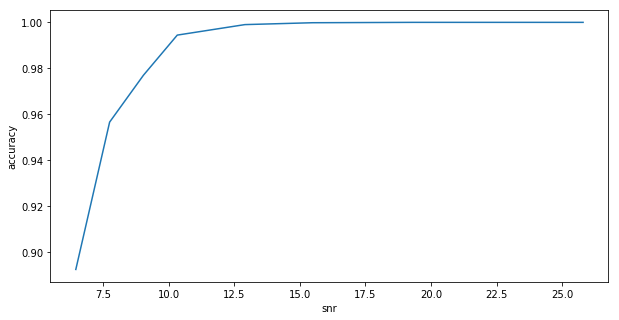

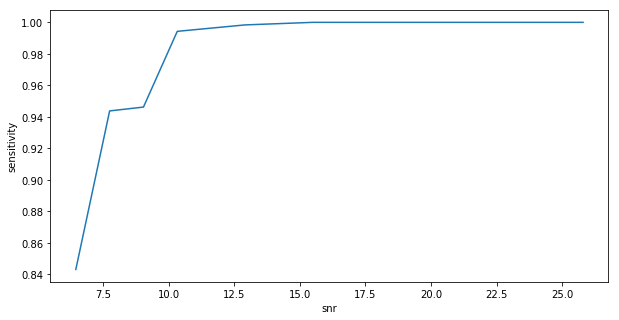

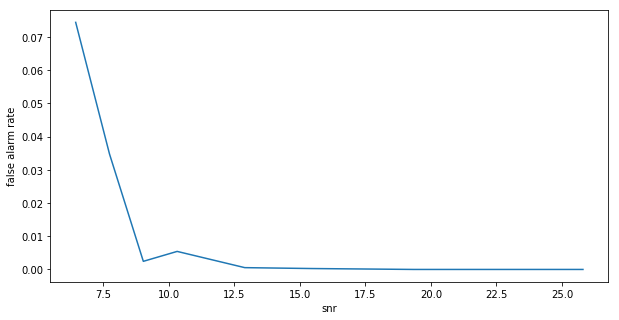

In [28]:
th = h5py.File('/Volumes/Mac/GW/traininghistory/traininghistory-resnet6', 'a')
plt.figure(figsize=(10,5))
plt.plot(th['pr'][...]*12.9,th['acc'][...])
plt.xlabel('snr')
plt.ylabel('accuracy')


plt.figure(figsize=(10,5))
plt.plot(th['pr'][...]*12.9,th['sen'][...])
plt.xlabel('snr')
plt.ylabel('sensitivity')

plt.figure(figsize=(10,5))
plt.plot(th['pr'][...]*12.9,th['far'][...])
plt.xlabel('snr')
plt.ylabel('false alarm rate')

plt.show()

#plt.savefig('training result_10',dpi=600)
th.close() 